# "Bottleneck" Features and Finetuning
Code for 10/1 lecture in CS 4774

## "Bottleneck" features

### Import convolutional base

In [1]:
import warnings
warnings.filterwarnings("ignore")

from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Feature extraction

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
# Change directory paths here to point to your own data

base_dir = './small_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Flatten features for input into densely connected classifier
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

NameError: name 'train_features' is not defined

In [17]:
np.save('./features/train_features.npy', train_features)
np.save('./features/train_labels.npy', train_labels)
np.save('./features/validation_features.npy', validation_features)
np.save('./features/validation_labels.npy', validation_labels)
np.save('./features/test_features.npy', test_features)
np.save('./features/test_labels.npy', test_labels)

### Train densely connected classifier

In [8]:
train_features = np.load('./features/train_features.npy')
train_labels = np.load('./features/train_labels.npy')

validation_features = np.load('./features/validation_features.npy')
validation_labels = np.load('./features/validation_labels.npy')

test_features = np.load('./features/test_features.npy')
test_labels = np.load('./features/test_labels.npy')

In [9]:
from keras import models
from keras import layers
from keras import optimizers

In [10]:
dense = models.Sequential()
dense.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
dense.add(layers.Dropout(0.5)) # Helps to regularize the network
dense.add(layers.Dense(1, activation='sigmoid')) # Sigmoid activation allows for classification

In [11]:
dense.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy', 
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
history = dense.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=[validation_features, validation_labels])


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 876us/step - loss: 0.6028 - acc: 0.6670 - val_loss: 0.4478 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 2s 757us/step - loss: 0.4413 - acc: 0.8025 - val_loss: 0.3702 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 2s 782us/step - loss: 0.3695 - acc: 0.8520 - val_loss: 0.3452 - val_acc: 0.8490
Epoch 4/30
2000/2000 [==============================] - 2s 886us/step - loss: 0.3256 - acc: 0.8690 - val_loss: 0.2999 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 2s 899us/step - loss: 0.2971 - acc: 0.8870 - val_loss: 0.2791 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 2s 903us/step - loss: 0.2775 - acc: 0.8920 - val_loss: 0.2700 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 2s 958us/step - loss: 0.2499 - acc: 0.9080 - val_loss: 0.2584 - val_acc: 0.8940

### Plotting results

In [13]:
import matplotlib.pyplot as plt

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

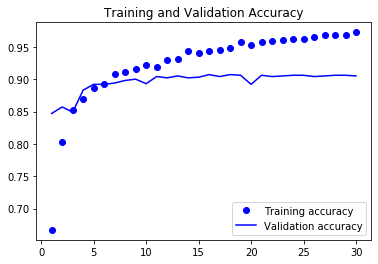

In [15]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

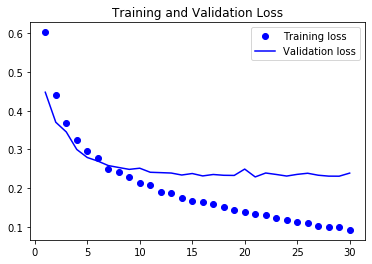

In [16]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Fine-tuning

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(dense)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2097665   
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [22]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/25
100/100 [==============================] - 182s 2s/step - loss: 0.0957 - acc: 0.9685 - val_loss: 0.0179 - val_acc: 0.8990
Epoch 2/25
100/100 [==============================] - 200s 2s/step - loss: 0.0489 - acc: 0.9850 - val_loss: 0.2509 - val_acc: 0.9130
Epoch 3/25
100/100 [==============================] - 179s 2s/step - loss: 0.0290 - acc: 0.9915 - val_loss: 0.0563 - val_acc: 0.8950
Epoch 4/25
100/100 [==============================] - 182s 2s/step - loss: 0.0175 - acc: 0.9970 - val_loss: 0.1481 - val_acc: 0.9210
Epoch 5/25
100/100 [==============================] - 178s 2s/step - loss: 0.0103 - acc: 0.9990 - val_loss: 0.0771 - val_acc: 0.9200
Epoch 6/25
100/100 [==============================] - 189s 2s/step - loss: 0.0067 - acc: 0.9990 - val_loss: 0.0980 - val_acc: 0.9230
Epoch 7/25
100/100 [==============================] - 184s 2s/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.1947 - val_acc: 0.9220
Epoch 8/25
100/100 [==============================] - 202s 2s/step - 

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

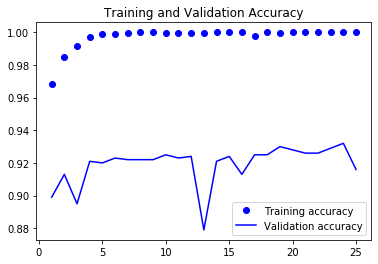

In [24]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

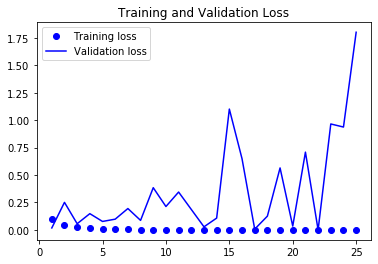

In [25]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()